In [ ]:
import numpy as np
import tensorflow as tf

import keras,os
#from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [ ]:
!unzip /content/drive/MyDrive/dataset/newx64new.zip

Streaming output truncated to the last 5000 lines.
  inflating: newx64 - Copy/NotFaces/new (1895).jpg  
  inflating: newx64 - Copy/NotFaces/new (1896).jpg  
  inflating: newx64 - Copy/NotFaces/new (1897).jpg  
  inflating: newx64 - Copy/NotFaces/new (1898).jpg  
  inflating: newx64 - Copy/NotFaces/new (1899).jpg  
  inflating: newx64 - Copy/NotFaces/new (19).jpg  
  inflating: newx64 - Copy/NotFaces/new (190).jpg  
  inflating: newx64 - Copy/NotFaces/new (1900).jpg  
  inflating: newx64 - Copy/NotFaces/new (1901).jpg  
  inflating: newx64 - Copy/NotFaces/new (1902).jpg  
  inflating: newx64 - Copy/NotFaces/new (1903).jpg  
  inflating: newx64 - Copy/NotFaces/new (1904).jpg  
  inflating: newx64 - Copy/NotFaces/new (1905).jpg  
  inflating: newx64 - Copy/NotFaces/new (1906).jpg  
  inflating: newx64 - Copy/NotFaces/new (1907).jpg  
  inflating: newx64 - Copy/NotFaces/new (1908).jpg  
  inflating: newx64 - Copy/NotFaces/new (1909).jpg  
  inflating: newx64 - Copy/NotFaces/new (191).jpg  

In [ ]:
#!unzip /content/drive/MyDrive/dataset/resnet50_weights_tf_dim_ordering_tf_kernels_notop.zip

Archive:  /content/drive/MyDrive/dataset/resnet50_weights_tf_dim_ordering_tf_kernels_notop.zip
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [ ]:
trainDir = "/content/dataset/train"
testDir = "/content/dataset/test/"
validationDir = "/content/dataset/validation/"
mainDir = "/content/newx64 - Copy/"
weightsPath = "/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
# Face & Non-Face
NUM_CLASSES = 2

# Accepted image input size for ResNet50 is 224
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 9

# How many steps we take in each epoch, i.e. train BATCH_SIZE for the amount of steps
STEPS_PER_EPOCH_TRAINING = 100
STEPS_PER_EPOCH_VALIDATION = 80

# The amount of images to use in each step
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100


In [ ]:
image_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)    

traindata = image_generator.flow_from_directory(batch_size=BATCH_SIZE_TRAINING,
                                                 directory=mainDir,
                                                 shuffle=True,
                                                 target_size=(IMAGE_RESIZE, IMAGE_RESIZE), 
                                                 subset="training",
                                                 class_mode='categorical')

validationdata = image_generator.flow_from_directory(batch_size=BATCH_SIZE_VALIDATION,
                                                 directory=mainDir,
                                                 shuffle=True,
                                                 target_size=(IMAGE_RESIZE, IMAGE_RESIZE), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 35074 images belonging to 2 classes.
Found 8768 images belonging to 2 classes.


In [ ]:
#RESNET50
model = Sequential()
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE))

# 2nd layer as Dense for classification
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#RESNET50
from keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [ ]:
(BATCH_SIZE_TRAINING, len(traindata), BATCH_SIZE_VALIDATION, len(validationdata))

(100, 351, 100, 88)

In [ ]:
# Early stopping & checkpointing the best model in my google drive dir, and then using that checkpoint for later predictions
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

modelOutPath = "/content/drive/MyDrive/dataset/out6.hdf5"

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = modelOutPath, monitor = 'val_loss', save_best_only = True, mode = 'auto')


In [ ]:
fit_history = model.fit_generator(
        traindata,
        epochs = NUM_EPOCHS,
        validation_data=validationdata,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights(modelOutPath)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
351/351 [==============================] - 199s 566ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 4.8681e-04 - val_accuracy: 0.9999
Epoch 2/50
351/351 [==============================] - 199s 567ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 5.1221e-04 - val_accuracy: 0.9997
Epoch 3/50
351/351 [==============================] - 199s 566ms/step - loss: 3.2740e-04 - accuracy: 0.9999 - val_loss: 2.5894e-04 - val_accuracy: 0.9999
Epoch 4/50
351/351 [==============================] - 199s 567ms/step - loss: 6.4672e-05 - accuracy: 1.0000 - val_loss: 1.8841e-04 - val_accuracy: 0.9999
Epoch 5/50
351/351 [==============================] - 199s 565ms/step - loss: 1.2244e-04 - accuracy: 1.0000 - val_loss: 2.4131e-04 - val_accuracy: 0.9999
Epoch 6/50
351/351 [==============================] - 198s 565ms/step - loss: 4.7279e-05 - accuracy: 1.0000 - val_loss: 3.2645e-04 - val_accuracy: 0.9998
Epoch 7/50
351/351 [==============================] - 199s 565ms/step - loss: 3.7682

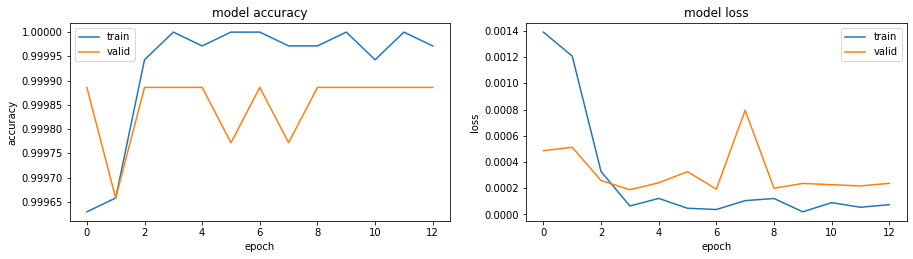

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
fit_history = model.fit_generator(
        traindata,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validationdata,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights(modelOutPath)